# 07c - XGBoost Baseline Only (Full 34.5K Dataset)

**Purpose**: Train and evaluate XGBoost baseline model WITHOUT any OCEAN features using FULL dataset (34.5K samples)

## Key Points:

- **Features**: Base features only (NO OCEAN features)
- **Data**: Full 34.5K samples (not 2K sample)
- **Model**: XGBoost with optimized hyperparameters
- **Focus**: Understand baseline performance and feature importance

## Evaluation Metrics:

- **Primary**: ROC-AUC
- **Secondary**: Accuracy, Precision, Recall, F1-Score
- **Analysis**: Feature importance, ROC curve, confusion matrix, calibration

**Estimated Time**: 10-15 minutes

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc as compute_auc
)

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries loaded successfully")
print(f"Timestamp: {datetime.now()}")

Libraries loaded successfully
Timestamp: 2025-10-31 13:36:28.375588


## Step 2: Configuration

In [2]:
CONFIG = {
    # Input file - FULL 34.5K DATASET
    'input_data': '../loan_final_desc50plus_with_ocean_bge.csv',
    
    # Output files
    'output_model_report': '../07c_xgboost_baseline_report.json',
    'output_visualization': '../07c_xgboost_baseline_visualization.png',
    'output_feature_importance': '../07c_baseline_feature_importance.csv',
    
    # Features to remove (high cardinality)
    'remove_features': ['emp_title', 'title', 'earliest_cr_line', 'desc'],
    
    # All OCEAN dimensions (to be removed)
    'ocean_dims': ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism'],
    'llm_models': ['llama', 'gpt', 'qwen', 'gemma', 'deepseek'],
    
    # Model parameters
    'xgboost_params': {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 10
    },
    
    # Train/test split
    'test_size': 0.2,
    'random_state': RANDOM_STATE,
}

print("Configuration:")
print(f"  Input data: {CONFIG['input_data']}")
print(f"  Test size: {CONFIG['test_size']*100:.0f}%")
print(f"\nXGBoost parameters:")
for k, v in CONFIG['xgboost_params'].items():
    print(f"  {k}: {v}")

Configuration:
  Input data: ../loan_final_desc50plus_with_ocean_bge.csv
  Test size: 20%

XGBoost parameters:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  eval_metric: logloss
  early_stopping_rounds: 10


## Step 3: Load Data

In [3]:
print("Loading data...")
df = pd.read_csv(CONFIG['input_data'], low_memory=False)
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")

# Check target column
if 'target' not in df.columns:
    raise ValueError("Missing target column!")

print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"Default rate: {df['target'].mean()*100:.2f}%")

print(f"\nData info:")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Missing values: {df.isnull().sum().sum():,}")

Loading data...
  Rows: 34,529
  Columns: 38

Target distribution:
target
0    29479
1     5050
Name: count, dtype: int64
Default rate: 14.63%

Data info:
  Memory usage: 56.63 MB
  Missing values: 2,872


## Step 4: Prepare Features (Remove OCEAN)

In [4]:
# Separate features and target
y = df['target'].copy()
X = df.drop(columns=['target'], errors='ignore').copy()

print(f"Initial feature set shape: {X.shape}")

# Remove high cardinality features
X = X.drop(columns=CONFIG['remove_features'], errors='ignore')
print(f"After removing high cardinality features: {X.shape}")

# Identify all OCEAN columns
all_ocean_cols = []
for llm in CONFIG['llm_models']:
    for dim in CONFIG['ocean_dims']:
        ocean_col = f"{llm}_{dim}"
        if ocean_col in X.columns:
            all_ocean_cols.append(ocean_col)

print(f"\nOCEAN columns found: {len(all_ocean_cols)}")
print(f"  OCEAN columns: {all_ocean_cols[:10]}...") # Show first 10

# Remove ALL OCEAN columns
X = X.drop(columns=all_ocean_cols, errors='ignore')
print(f"\nAfter removing ALL OCEAN features: {X.shape}")

# Show feature breakdown
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature breakdown:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total features: {len(numeric_features) + len(categorical_features)}")

Initial feature set shape: (34529, 37)
After removing high cardinality features: (34529, 33)

OCEAN columns found: 0
  OCEAN columns: []...

After removing ALL OCEAN features: (34529, 33)

Feature breakdown:
  Numeric features: 21
  Categorical features: 12
  Total features: 33


## Step 5: Train/Test Split

In [5]:
print("Performing train/test split (80/20)...\n")

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

print(f"Training set: {len(y_train):,} samples ({len(y_train)/len(y)*100:.1f}%)")
print(f"Test set: {len(y_test):,} samples ({len(y_test)/len(y)*100:.1f}%)")

print(f"\nTarget distribution in train set:")
print(y_train.value_counts())
print(f"Default rate (train): {y_train.mean()*100:.2f}%")

print(f"\nTarget distribution in test set:")
print(y_test.value_counts())
print(f"Default rate (test): {y_test.mean()*100:.2f}%")

Performing train/test split (80/20)...

Training set: 27,623 samples (80.0%)
Test set: 6,906 samples (20.0%)

Target distribution in train set:
target
0    23583
1     4040
Name: count, dtype: int64
Default rate (train): 14.63%

Target distribution in test set:
target
0    5896
1    1010
Name: count, dtype: int64
Default rate (test): 14.62%


## Step 6: Create and Apply Preprocessing Pipeline

In [6]:
# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Feature preprocessing:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Categorical features: {len(categorical_features)}")

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
print(f"\nApplying preprocessing...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"  Train shape after preprocessing: {X_train_processed.shape}")
print(f"  Test shape after preprocessing: {X_test_processed.shape}")

Feature preprocessing:
  Numeric features: 21
  Categorical features: 12

Applying preprocessing...
  Train shape after preprocessing: (27623, 1064)
  Test shape after preprocessing: (6906, 1064)


## Step 7: Train XGBoost Model

In [7]:
# Calculate class weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class weight (scale_pos_weight): {scale_pos_weight:.4f}")

# Update parameters
xgb_params = CONFIG['xgboost_params'].copy()
xgb_params['scale_pos_weight'] = scale_pos_weight

print(f"\nTraining XGBoost Baseline Model...")
print(f"Parameters: {xgb_params}")

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

model.fit(
    X_train_processed, y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=False
)

print(f"Model training completed!")

Class weight (scale_pos_weight): 5.8374

Training XGBoost Baseline Model...
Parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'eval_metric': 'logloss', 'early_stopping_rounds': 10, 'scale_pos_weight': 5.837376237623762}
Model training completed!


## Step 8: Model Evaluation

In [8]:
# Generate predictions
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print("="*60)
print("BASELINE MODEL PERFORMANCE (Full 34.5K Dataset)")
print("="*60)

print(f"\nKey Metrics:")
print(f"  ROC-AUC:   {auc:.4f}")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

print(f"\nConfusion Matrix:")
print(f"  TN: {cm[0, 0]:,}  |  FP: {cm[0, 1]:,}")
print(f"  FN: {cm[1, 0]:,}  |  TP: {cm[1, 1]:,}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

BASELINE MODEL PERFORMANCE (Full 34.5K Dataset)

Key Metrics:
  ROC-AUC:   0.6995
  Accuracy:  0.6911
  Precision: 0.2532
  Recall:    0.5703
  F1-Score:  0.3507

Confusion Matrix:
  TN: 4,197  |  FP: 1,699
  FN: 434  |  TP: 576

Detailed Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.91      0.71      0.80      5896
     Default       0.25      0.57      0.35      1010

    accuracy                           0.69      6906
   macro avg       0.58      0.64      0.57      6906
weighted avg       0.81      0.69      0.73      6906



## Step 9: Feature Importance Analysis

In [9]:
# Get feature importance
feature_importance = model.feature_importances_
n_features = X_train_processed.shape[1]

# Create feature names after preprocessing
numeric_cols = numeric_features.copy()
cat_processed = []

# Get one-hot encoded feature names
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
try:
    # Get feature names from onehot encoder for all categorical features
    feature_names_cat = onehot_encoder.get_feature_names_out(categorical_features)
    cat_processed = list(feature_names_cat)
except Exception as e:
    print(f"Warning: Could not get categorical feature names: {e}")
    # Fallback: create generic names
    cat_processed = [f"cat_feature_{i}" for i in range(len(categorical_features))]

feature_names = numeric_cols + cat_processed

# Ensure we have the right number of feature names
if len(feature_names) > n_features:
    feature_names = feature_names[:n_features]
elif len(feature_names) < n_features:
    # Pad with generic names if needed
    feature_names = feature_names + [f"feature_{i}" for i in range(len(feature_names), n_features)]

# Create dataframe
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
print(df_importance.head(20).to_string(index=False))

# Save feature importance
df_importance.to_csv(CONFIG['output_feature_importance'], index=False)
print(f"\nFeature importance saved to: {CONFIG['output_feature_importance']}")


Top 20 Most Important Features:
               feature  importance
               grade_A      0.0754
               grade_B      0.0189
       term_ 60 months      0.0159
              int_rate      0.0098
       term_ 36 months      0.0085
        zip_code_986xx      0.0057
purpose_small_business      0.0055
               grade_C      0.0045
        zip_code_322xx      0.0043
        zip_code_750xx      0.0043
         addr_state_CO      0.0043
   purpose_credit_card      0.0042
        zip_code_601xx      0.0042
         addr_state_LA      0.0041
        zip_code_223xx      0.0041
          sub_grade_A4      0.0041
        zip_code_017xx      0.0041
        zip_code_333xx      0.0041
        zip_code_331xx      0.0040
         purpose_other      0.0040

Feature importance saved to: ../07c_baseline_feature_importance.csv


## Step 10: Visualizations

Visualization saved to: ../07c_xgboost_baseline_visualization.png


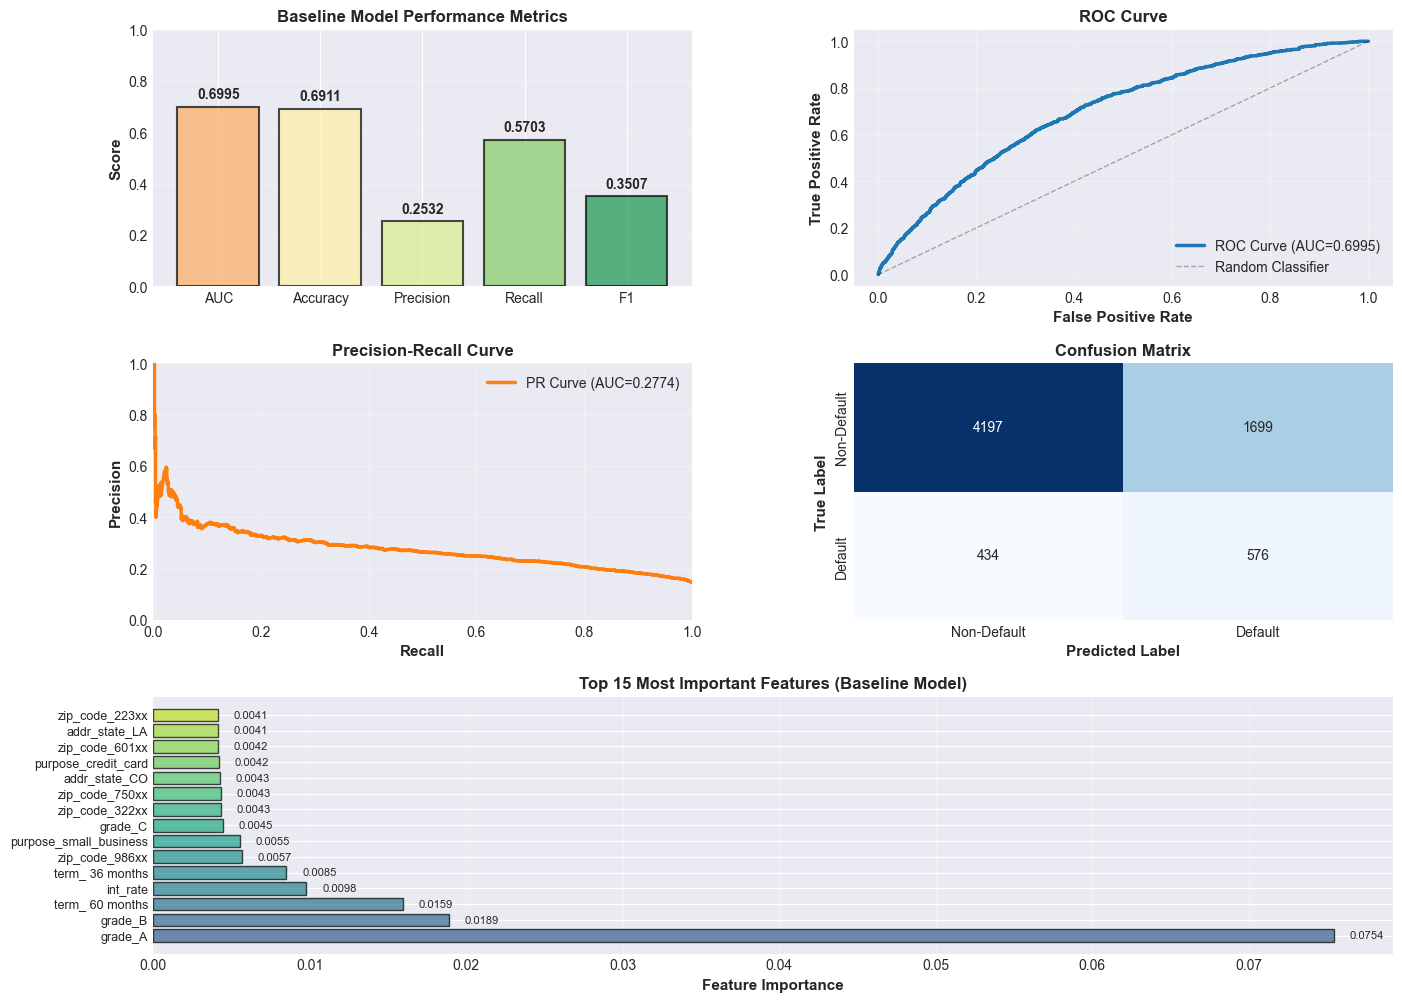

In [10]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Performance Metrics
ax1 = fig.add_subplot(gs[0, 0])
metrics_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
metrics_values = [auc, accuracy, precision, recall, f1]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(metrics_names)))

bars = ax1.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Baseline Model Performance Metrics', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_val = compute_auc(fpr, tpr)

ax2.plot(fpr, tpr, linewidth=2.5, color='#1f77b4', label=f'ROC Curve (AUC={auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3, label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

# 3. Precision-Recall Curve
ax3 = fig.add_subplot(gs[1, 0])
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc_val = compute_auc(recall_curve, precision_curve)

ax3.plot(recall_curve, precision_curve, linewidth=2.5, color='#ff7f0e', label=f'PR Curve (AUC={pr_auc_val:.4f})')
ax3.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(alpha=0.3)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# 4. Confusion Matrix
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax4,
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
ax4.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax4.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# 5. Top 15 Feature Importance
ax5 = fig.add_subplot(gs[2, :])
top_features = df_importance.head(15)

bars = ax5.barh(range(len(top_features)), top_features['importance'].values,
                 color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features))),
                 alpha=0.7, edgecolor='black')
ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels(top_features['feature'].values, fontsize=9)
ax5.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax5.set_title('Top 15 Most Important Features (Baseline Model)', fontsize=12, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax5.text(row['importance'] + 0.001, i, f"{row['importance']:.4f}",
             va='center', fontsize=8)

plt.savefig(CONFIG['output_visualization'], dpi=300, bbox_inches='tight')
print(f"Visualization saved to: {CONFIG['output_visualization']}")
plt.show()

## Step 11: Generate Final Report

In [11]:
# Generate comprehensive report
report = {
    'experiment': '07c_xgboost_baseline_only_full_34k',
    'timestamp': datetime.now().isoformat(),
    'description': 'XGBoost Baseline Model trained on full 34.5K dataset WITHOUT any OCEAN features',
    
    'dataset': {
        'total_samples': int(len(df)),
        'train_samples': int(len(y_train)),
        'test_samples': int(len(y_test)),
        'total_features': int(X.shape[1]),
        'default_rate': float(y.mean()),
        'default_rate_percent': float(y.mean() * 100)
    },
    
    'model_config': {
        'model_type': 'XGBClassifier',
        'parameters': CONFIG['xgboost_params'],
        'class_weight': float(scale_pos_weight)
    },
    
    'performance_metrics': {
        'roc_auc': float(auc),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'pr_auc': float(pr_auc_val)
    },
    
    'confusion_matrix': {
        'true_negatives': int(cm[0, 0]),
        'false_positives': int(cm[0, 1]),
        'false_negatives': int(cm[1, 0]),
        'true_positives': int(cm[1, 1])
    },
    
    'top_features': df_importance.head(20).to_dict('records')
}

# Save report
with open(CONFIG['output_model_report'], 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*60)
print("FINAL SUMMARY - BASELINE MODEL (Full 34.5K Dataset)")
print("="*60)

print(f"\nDataset Information:")
print(f"  Total samples: {len(df):,}")
print(f"  Train samples: {len(y_train):,}")
print(f"  Test samples: {len(y_test):,}")
print(f"  Total features: {X.shape[1]}")
print(f"  Default rate: {y.mean()*100:.2f}%")

print(f"\nPerformance Metrics:")
print(f"  ROC-AUC: {auc:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  PR-AUC: {pr_auc_val:.4f}")

print(f"\nTop 5 Most Important Features:")
for i, row in df_importance.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.6f}")

print(f"\nOutput files generated:")
print(f"  Report: {CONFIG['output_model_report']}")
print(f"  Visualization: {CONFIG['output_visualization']}")
print(f"  Feature Importance: {CONFIG['output_feature_importance']}")

print(f"\nAnalysis complete!")


FINAL SUMMARY - BASELINE MODEL (Full 34.5K Dataset)

Dataset Information:
  Total samples: 34,529
  Train samples: 27,623
  Test samples: 6,906
  Total features: 33
  Default rate: 14.63%

Performance Metrics:
  ROC-AUC: 0.6995
  Accuracy: 0.6911
  Precision: 0.2532
  Recall: 0.5703
  F1-Score: 0.3507
  PR-AUC: 0.2774

Top 5 Most Important Features:
  24. grade_A: 0.075419
  25. grade_B: 0.018927
  23. term_ 60 months: 0.015949
  3. int_rate: 0.009804
  22. term_ 36 months: 0.008525

Output files generated:
  Report: ../07c_xgboost_baseline_report.json
  Visualization: ../07c_xgboost_baseline_visualization.png
  Feature Importance: ../07c_baseline_feature_importance.csv

Analysis complete!
